In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# Reading in temps data
temps = pd.read_excel("original data/Temps Data full.xls", sheet_name = None)
frames = [df for sheet, df in temps.items()]
temps_full = pd.concat(frames)

In [3]:
pd.unique(temps_full["NRG_STREAM_NAME"])

array(['EC - Calgary Temp', 'EC - Fort McMurray Temp',
       'EC - Lethbridge Temp', 'EC - Edmonton Temp'], dtype=object)

In [4]:
yyc_temp = temps_full[temps_full["NRG_STREAM_NAME"] == "EC - Calgary Temp"]

fort_temp = temps_full[temps_full["NRG_STREAM_NAME"] == "EC - Fort McMurray Temp"]

lethbridge_temp = temps_full[temps_full["NRG_STREAM_NAME"] == 'EC - Lethbridge Temp']

edmonton_temp = temps_full[temps_full["NRG_STREAM_NAME"] == 'EC - Edmonton Temp']

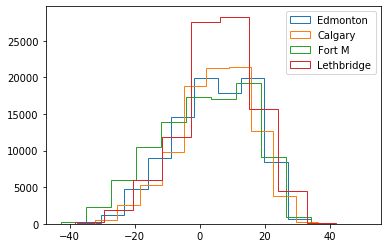

In [5]:
bins = np.linspace(-60, 40, 50)


plt.hist(edmonton_temp["TEMP_CELSIUS"], 
         histtype= 'step', label='Edmonton')

plt.hist(yyc_temp["TEMP_CELSIUS"], histtype= 'step', label='Calgary')
plt.hist(fort_temp["TEMP_CELSIUS"],  histtype= 'step', label='Fort M')
plt.hist(lethbridge_temp["TEMP_CELSIUS"],  histtype= 'step', label='Lethbridge')
plt.legend(loc='upper right')
plt.show()

In [7]:
full_time = pd.DataFrame( pd.date_range(start='2010-01-01 07:00:00', end = '2021-01-05 07:00:00', freq='H'), 
                         columns = ["FULL_BEGIN_DATE_GMT"] )

def merge_full_time(df, full_time):
    return full_time.merge(df, how ="left",
                           left_on =  "FULL_BEGIN_DATE_GMT",
                           right_on = "BEGIN_DATE_GMT")


In [8]:
yyc_temp = merge_full_time(yyc_temp, full_time)
fort_temp = merge_full_time(fort_temp, full_time)
lethbridge_temp =  merge_full_time(lethbridge_temp, full_time)
edmonton_temp =  merge_full_time(edmonton_temp, full_time)

In [9]:
yyc_temp.head()

,FULL_BEGIN_DATE_GMT,BEGIN_DATE_GMT,END_DATE_GMT,SOURCE_DATETIME,SOURCE_TIMEZONE,NRG_STREAM_NAME,TEMP_CELSIUS,VERSION_BEGIN_LOCAL,VERSION_END_LOCAL
0,2010-01-01 07:00:00,2010-01-01 07:00:00,2010-01-01 08:00:00,2010-01-01 00:00:00,MST,EC - Calgary Temp,-21.7,2020-03-02 09:02:14,NaN
1,2010-01-01 08:00:00,2010-01-01 08:00:00,2010-01-01 09:00:00,2010-01-01 01:00:00,MST,EC - Calgary Temp,-21.3,2020-03-02 09:02:14,NaN
2,2010-01-01 09:00:00,2010-01-01 09:00:00,2010-01-01 10:00:00,2010-01-01 02:00:00,MST,EC - Calgary Temp,-21.0,2020-03-02 09:02:14,NaN
3,2010-01-01 10:00:00,2010-01-01 10:00:00,2010-01-01 11:00:00,2010-01-01 03:00:00,MST,EC - Calgary Temp,-20.4,2020-03-02 09:02:14,NaN
4,2010-01-01 11:00:00,2010-01-01 11:00:00,2010-01-01 12:00:00,2010-01-01 04:00:00,MST,EC - Calgary Temp,-20.4,2020-03-02 09:02:14,NaN


In [10]:
yyc_na = yyc_temp[ pd.isna(yyc_temp["TEMP_CELSIUS"])]["FULL_BEGIN_DATE_GMT"]
fmm_na = fort_temp[ pd.isna(fort_temp["TEMP_CELSIUS"])]["FULL_BEGIN_DATE_GMT"]
lb_na = lethbridge_temp[pd.isna(lethbridge_temp["TEMP_CELSIUS"])]["FULL_BEGIN_DATE_GMT"]
edm_na = edmonton_temp[ pd.isna(edmonton_temp["TEMP_CELSIUS"])]["FULL_BEGIN_DATE_GMT"]

for df in [yyc_na, fmm_na, lb_na, edm_na]:
    print( df.shape ) 

(44,)
(40,)
(232,)
(44,)


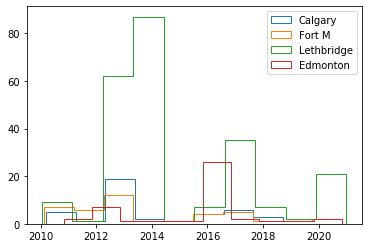

In [13]:
bins = np.linspace(-60, 40, 50)
plt.hist(yyc_na, 
         histtype= 'step', label='Calgary')
plt.hist(fmm_na,  
         histtype= 'step', label='Fort M')
plt.hist(lb_na,  
         histtype= 'step', label='Lethbridge')
plt.hist(edm_na, 
         histtype= 'step', label='Edmonton')
plt.legend(loc='upper right')
plt.show()

In [21]:
times_gaps = (lb_na - lb_na.shift(1)) / pd.Timedelta(hours=1)
px.scatter(x = lb_na[times_gaps == 1],y = times_gaps[times_gaps == 1])

In [95]:
# Reading in population data
pop_low_growth = pd.read_csv("original data/2020-2046-05-census-divisions-population-projections-low.csv",
                            dtype={'Year':int, 'Region': str, 'Sex': str, 'Age': str,'Pop': int })

pop_med_growth = pd.read_csv("original data/2020-2046-07-census-divisions-population-projections-medium.csv",
                             dtype={'Year':int, 'Region': str, 'Sex': str, 'Age': str,'Pop': int })

pop_high_growth = pd.read_csv("original data/2020-2046-09-census-divisions-population-projections-high.csv",
                             dtype={'Year':int, 'Region': str, 'Sex': str, 'Age': str,'Pop': int })

In [105]:
pop_full = pd.DataFrame(data = {"Year": pop_low_growth["Year"],
                               "Region": pop_low_growth["Region"],
                                "Sex": pop_low_growth["Sex"],
                                "Age": pop_low_growth["Age"],
                               "pop_low": pop_low_growth["Pop"],
                               "pop_medium": pop_med_growth["Pop"],
                                "pop_high": pop_high_growth["Pop"]
                               })

cd_divisions = ["2","6","11","16"]

def base_filter(df):
    period = (df["Year"] >= 2010)
    in_4_metros = df["Region"].apply(lambda x: x in cd_divisions)
    conditions = period & in_4_metros & (df["Sex"] == "3") & (df["Age"] =="Total")
              
    return df[conditions][df.columns.difference(["Sex","Age"])]

pop_metros =  base_filter(pop_full)


In [106]:
pop_metros.head()

,Region,Year,pop_high,pop_low,pop_medium
34684,2,2010,160510,160510,160510
34776,2,2011,162039,162039,162039
34868,2,2012,164123,164123,164123
34960,2,2013,166601,166601,166601
35052,2,2014,169720,169720,169720
